In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


**IMPORT LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


**LOADING THE DATA**

In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

# Display the first few rows of the train data
train_data.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


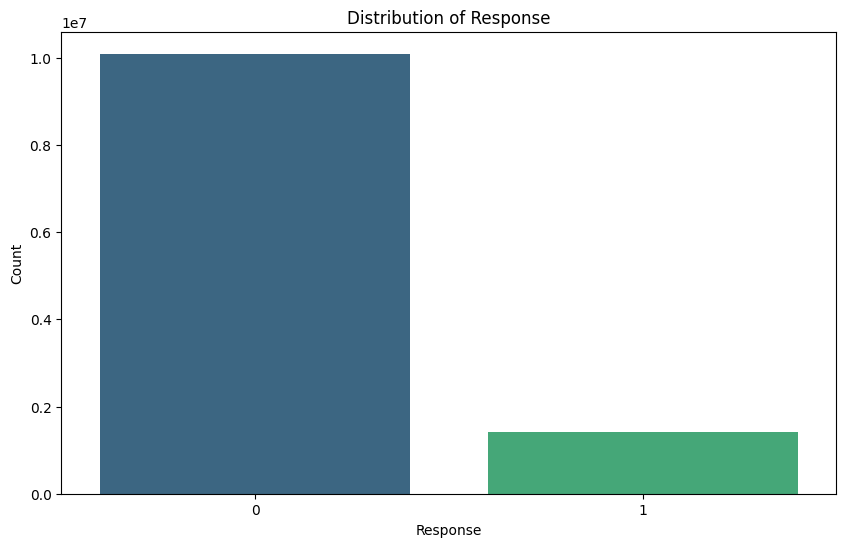

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_distribution(df, column_name):
    """
    Plot the distribution of a column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, palette='viridis')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# Example usage:
plot_column_distribution(train_data, 'Response')


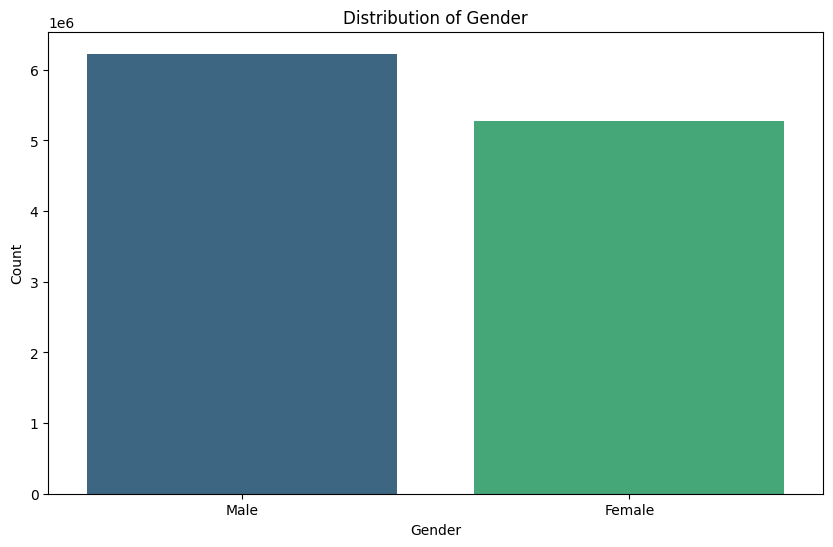

In [5]:
def plot_column_distribution(df, column_name):
    """
    Plot the distribution of a column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, palette='viridis')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# Example usage:
plot_column_distribution(train_data, 'Gender')

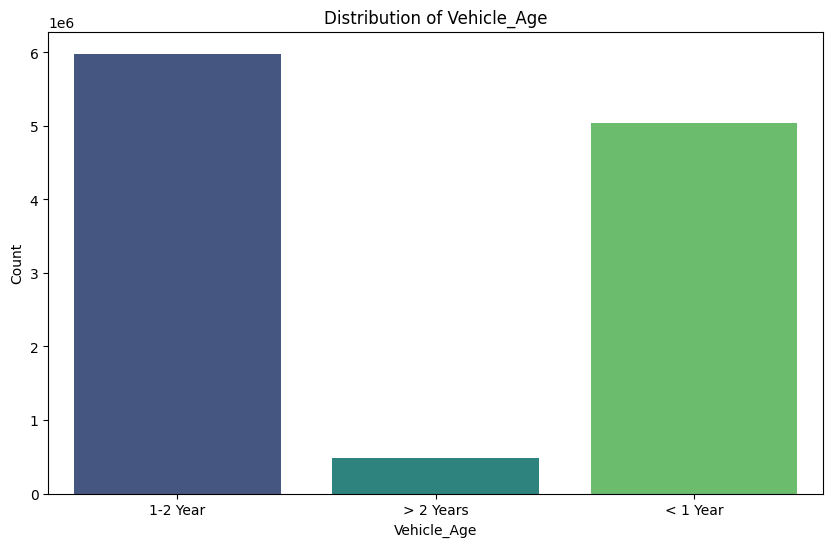

In [6]:
def plot_column_distribution(df, column_name):
    """
    Plot the distribution of a column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, palette='viridis')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# Example usage:
plot_column_distribution(train_data, 'Vehicle_Age')

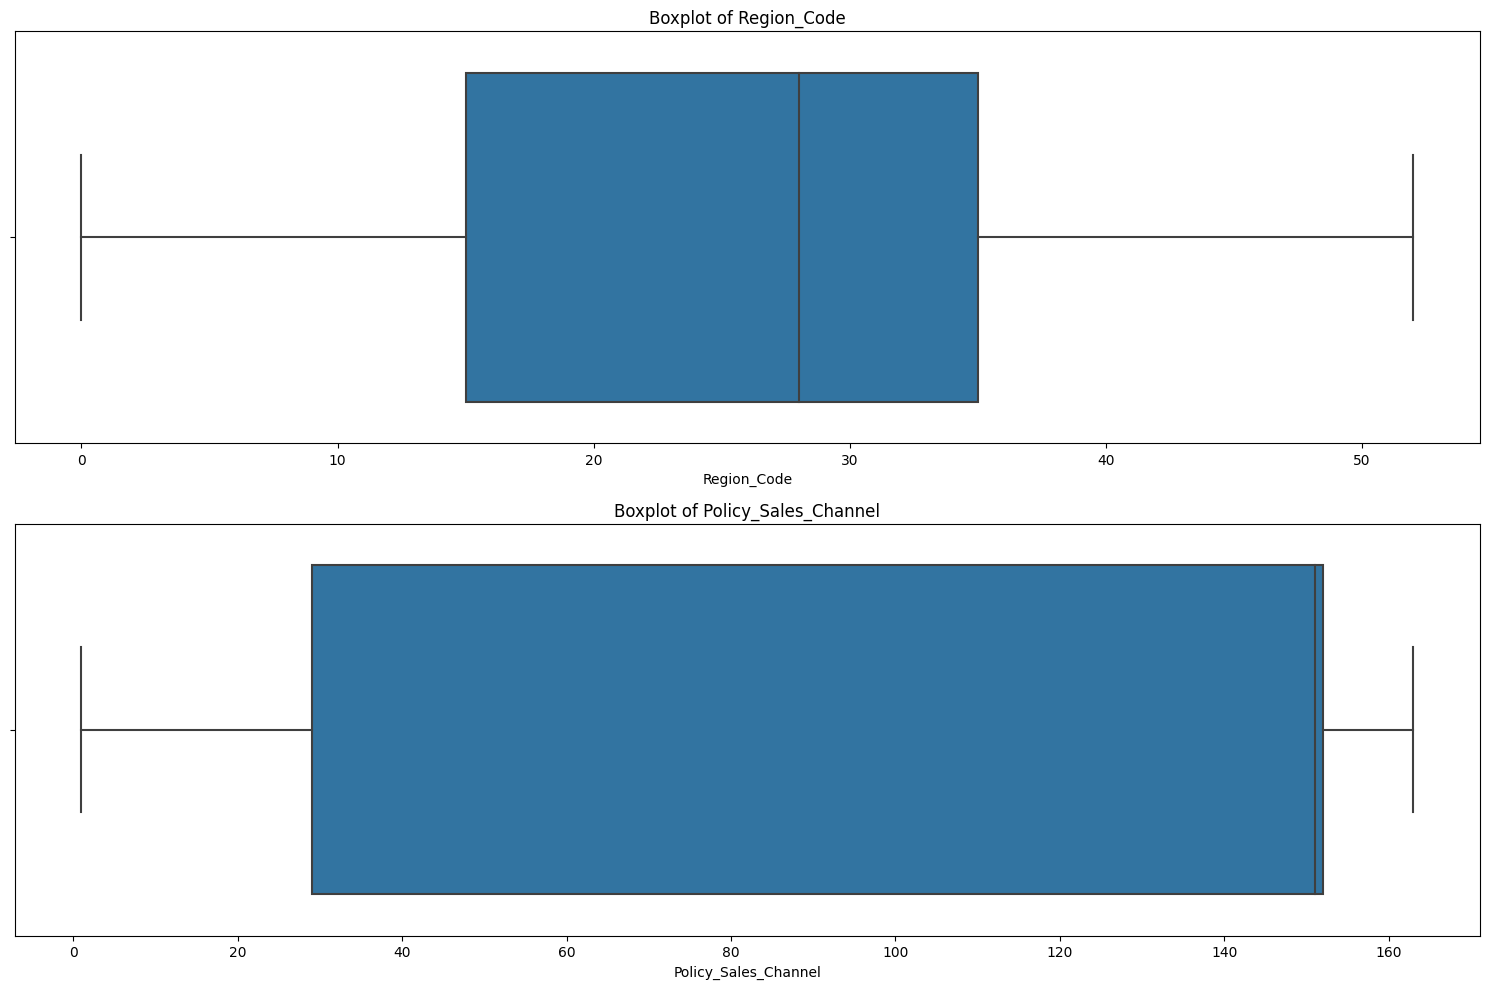

In [7]:
def plot_selected_numerical_boxplots(df, features):
    """
    Plot boxplots for selected numerical features in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    features (list): List of column names to plot.
    """
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')
        plt.tight_layout()
        
    plt.show()

# Define the features to plot
features_to_plot = ['Region_Code', 'Policy_Sales_Channel']

# Call the function
plot_selected_numerical_boxplots(train_data, features_to_plot)

**DATA EXPLORATION AND CLEANING**

In [8]:
# Check for missing values
train_data.isnull().sum()

# Check basic statistics
train_data.describe()

# Check the data types
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


**PREPROCESSING**

In [9]:
# Separate features and target variable from training data
X = train_data.drop(columns=['id', 'Response'])
y = train_data['Response']

# For the test set, we only need to drop the 'id' column
X_test = test_data.drop(columns=['id'])

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create and evaluate the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])


**MODEL TRAINING AND EVALUATION**

In [10]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
y_pred_proba = clf.predict_proba(X_val)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'Validation ROC AUC: {roc_auc}')


Validation ROC AUC: 0.8446248153594871


In [11]:
# Predict probabilities on the test set
test_proba = clf.predict_proba(X_test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({'id': test_data['id'], 'Response': test_proba})

# Save to CSV
submission.to_csv('submission.csv', index=False)
